In [2]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'

from pm4py import *
from pm4py.algo.simulation.playout.petri_net import algorithm as simulator
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.objects.conversion.process_tree import converter as pt_converter

import pandas as pd
from datetime import date
import seaborn as sns

## 1.	Загрузка бизнес-процесса и преобразование его в сеть Петри

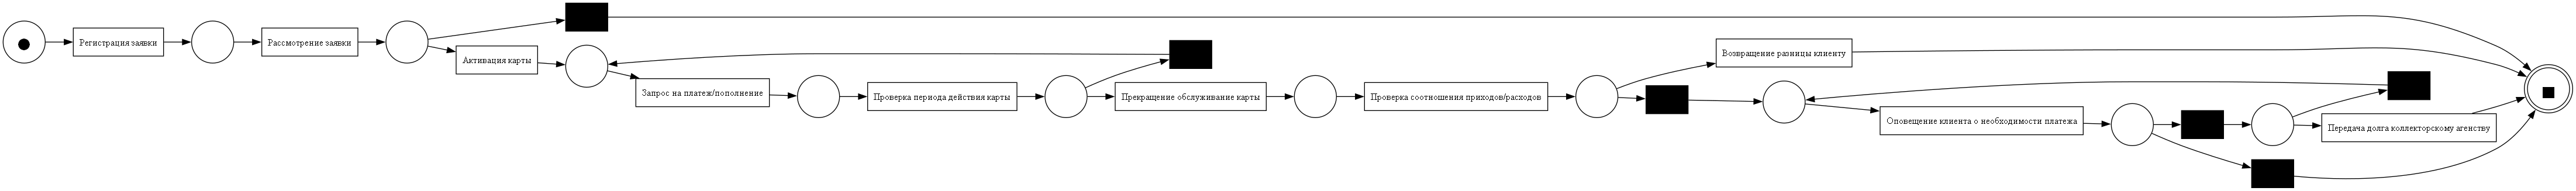

In [3]:
bpmn_graph = read_bpmn('bank_less.bpmn')
net,im,fm = convert_to_petri_net(bpmn_graph)

gviz=pn_visualizer.apply(net,im,fm)
pn_visualizer.view(gviz)

## 2.Построение графа достижимости маркировок


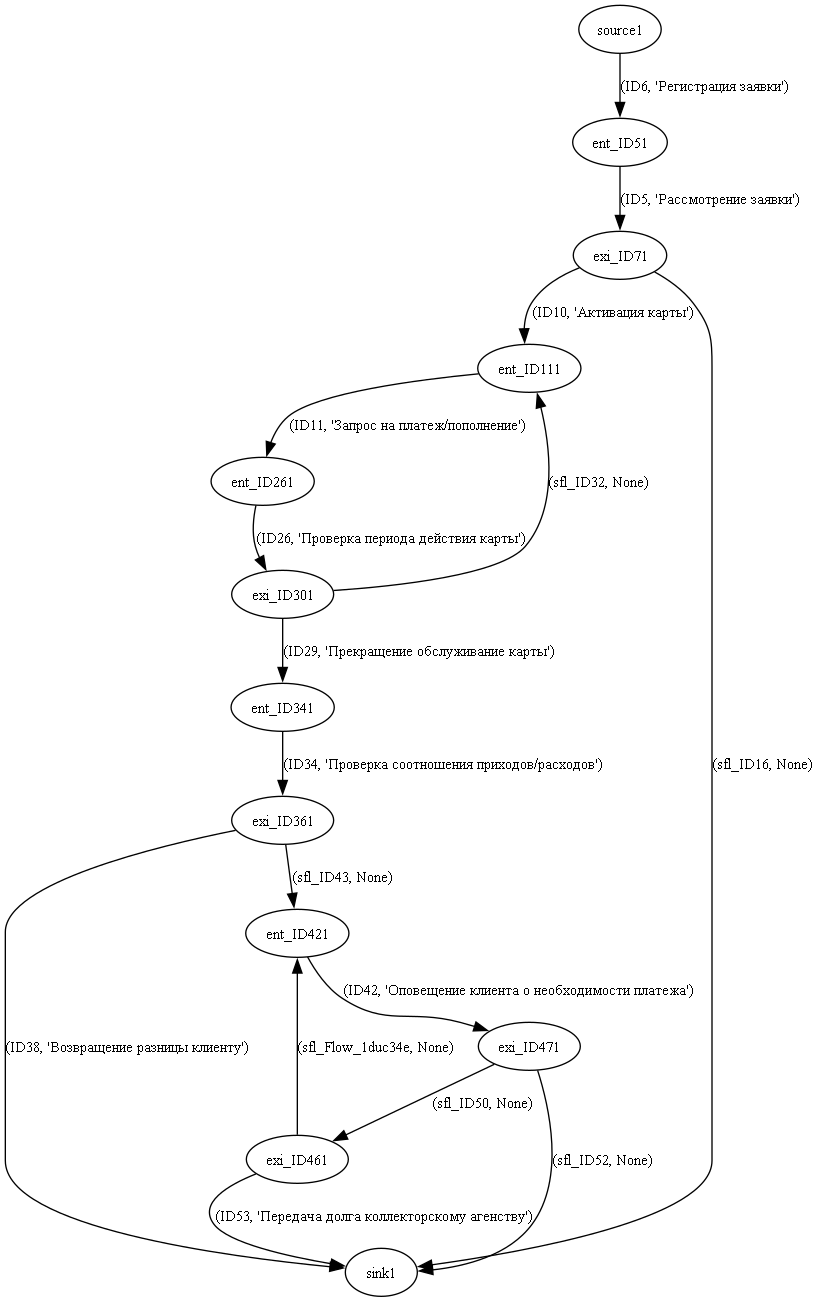

In [4]:
net, initial_marking, final_marking = convert_to_petri_net(bpmn_graph)

from pm4py.objects.petri_net.utils import reachability_graph
ts=reachability_graph.construct_reachability_graph(net,initial_marking)

from pm4py.visualization.transition_system import visualizer as ts_visualizer
gviz=ts_visualizer.apply(ts,parameters={ts_visualizer.Variants.VIEW_BASED.value.Parameters.FORMAT:"png"})
ts_visualizer.view(gviz)

## 3.Анализ бездеффектности 
**WOFLAN**

In [5]:
net, initial_marking, final_marking = convert_to_petri_net(bpmn_graph)

from pm4py.algo.analysis.woflan import algorithm as woflan

is_sound = woflan.apply(net, initial_marking, final_marking, parameters={woflan.Parameters.RETURN_ASAP_WHEN_NOT_SOUND: True,
                                                     woflan.Parameters.PRINT_DIAGNOSTICS: True,
                                                     woflan.Parameters.RETURN_DIAGNOSTICS: True})


print("\nIs Workflow net sound? ->", is_sound[0])


Input is ok.
Petri Net is a workflow net.
Every place is covered by s-components.
There are no dead tasks.
All tasks are live.

Is Workflow net sound? -> True


## 4.Генерация журнала событий 

c:\Python311\Lib\site-packages\pm4py\utils.py:537: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
exporting log, completed traces :: 100%|██████████| 50/50 [00:00<00:00, 16607.16it/s]


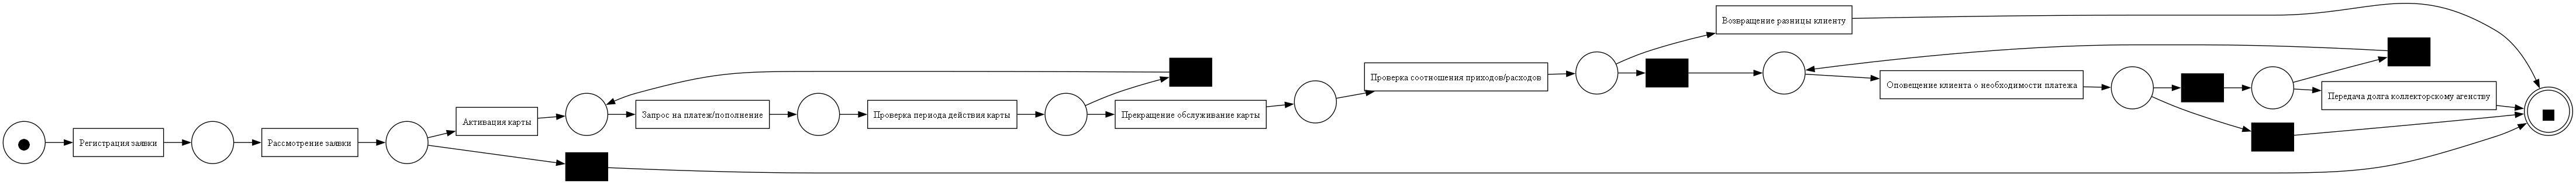

In [9]:
simulated_log = simulator.apply(net, initial_marking, variant=simulator.Variants.BASIC_PLAYOUT,
                                    parameters={simulator.Variants.BASIC_PLAYOUT.value.Parameters.NO_TRACES: 50})

write_xes(simulated_log, 'log.xes')

gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

dataframe = convert_to_dataframe(simulated_log)
dataframe.to_csv('exp.csv')


In [7]:
df = pd.read_csv("exp.csv", index_col=0)
df = df.rename(columns={"case:concept:name": "client", "time:timestamp": "datetime", "concept:name": "action"})
df['resource'] = ''
df.head(10)

,action,datetime,client,resource
0,Регистрация заявки,1970-04-26 20:46:40,0,
1,Рассмотрение заявки,1970-04-26 20:46:41,0,
2,Активация карты,1970-04-26 20:46:42,0,
3,Запрос на платеж/пополнение,1970-04-26 20:46:43,0,
4,Проверка периода действия карты,1970-04-26 20:46:44,0,
5,Запрос на платеж/пополнение,1970-04-26 20:46:45,0,
6,Проверка периода действия карты,1970-04-26 20:46:46,0,
7,Запрос на платеж/пополнение,1970-04-26 20:46:47,0,
8,Проверка периода действия карты,1970-04-26 20:46:48,0,
9,Прекращение обслуживание карты,1970-04-26 20:46:49,0,


In [10]:
seller = ['Регистрация заявки', 'Активация карты']
sales_manager = ['Рассмотрение заявки']
financial_service_officer = ['Оповещение клиента о необходимости платежа', 'Передача долга коллекторскому агенству']
client = ['Запрос на платеж/пополнение']
information_system = ['Проверка периода действия карты', 'Прекращение обслуживание карты', 'Проверка соотношения приходов/расходов', 'Возвращение разницы клиенту']

for row_inx in range(df.shape[0]):
    if df.iloc[row_inx, 0] in seller:
        df['resource'][row_inx] = 'Сотрудник отдела продаж'
    if df.iloc[row_inx, 0] in sales_manager:
        df['resource'][row_inx] = 'Менеджер отдела продаж'
    if df.iloc[row_inx, 0] in financial_service_officer:
        df['resource'][row_inx] = 'Сотрудник финансовой службы'
    if df.iloc[row_inx, 0] in client:
        df['resource'][row_inx] = 'Клиент'
    if df.iloc[row_inx, 0] in information_system:
        df['resource'][row_inx] = 'Информационная система'

C:\Users\cool1\AppData\Local\Temp\ipykernel_46000\3674449803.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['resource'][row_inx] = 'Сотрудник отдела продаж'
C:\Users\cool1\AppData\Local\Temp\ipykernel_46000\3674449803.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['resource'][row_inx] = 'Менеджер отдела продаж'
C:\Users\cool1\AppData\Local\Temp\ipykernel_46000\3674449803.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [11]:
df.head(10)

,action,datetime,client,resource
0,Регистрация заявки,1970-04-26 20:46:40,0,Сотрудник отдела продаж
1,Рассмотрение заявки,1970-04-26 20:46:41,0,Менеджер отдела продаж
2,Активация карты,1970-04-26 20:46:42,0,Сотрудник отдела продаж
3,Запрос на платеж/пополнение,1970-04-26 20:46:43,0,Клиент
4,Проверка периода действия карты,1970-04-26 20:46:44,0,Информационная система
5,Запрос на платеж/пополнение,1970-04-26 20:46:45,0,Клиент
6,Проверка периода действия карты,1970-04-26 20:46:46,0,Информационная система
7,Запрос на платеж/пополнение,1970-04-26 20:46:47,0,Клиент
8,Проверка периода действия карты,1970-04-26 20:46:48,0,Информационная система
9,Прекращение обслуживание карты,1970-04-26 20:46:49,0,Информационная система


In [12]:
df.to_csv('log.csv')

## 5.Предварительный анализ журнала событий

In [13]:
events = pd.read_csv('log.csv', index_col=0)
events['datetime'] = pd.to_datetime(events['datetime'])
events.head()

,action,datetime,client,resource
0,Регистрация заявки,1970-04-26 20:46:40,0,Сотрудник отдела продаж
1,Рассмотрение заявки,1970-04-26 20:46:41,0,Менеджер отдела продаж
2,Активация карты,1970-04-26 20:46:42,0,Сотрудник отдела продаж
3,Запрос на платеж/пополнение,1970-04-26 20:46:43,0,Клиент
4,Проверка периода действия карты,1970-04-26 20:46:44,0,Информационная система


In [14]:
print(f'Event log has {events.shape[0]} rows and {events.shape[1]} columns.')

Event log has 277 rows and 4 columns.


In [15]:
## Get the case start times to get the time deltas for the 'age' of each activity with respect to start
case_starts_ends = events.pivot_table(index='client', aggfunc={'datetime': ['min', 'max']})
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['client', 'caseend', 'casestart']
events = events.merge(case_starts_ends, on='client')
events['relativetime'] = (events['caseend']) - events['casestart']

## Get day of week
events['weekday'] = events['datetime'].apply(lambda x: x.weekday())
events['date'] = events['datetime'].apply(lambda x: x.date())
events['startdate'] = events['casestart'].apply(lambda x: x.date())
events['hour'] = events['datetime'].apply(lambda x: x.time().hour)

## Get relative times in more friendly terms
events['relativetime_s'] = events['relativetime'].dt.seconds + 86400*events['relativetime'].dt.days
events['relativedays'] = events['relativetime'].dt.days

events.head()

,action,datetime,client,resource,caseend,casestart,relativetime,weekday,date,startdate,hour,relativetime_s,relativedays
0,Регистрация заявки,1970-04-26 20:46:40,0,Сотрудник отдела продаж,1970-04-26 20:46:52,1970-04-26 20:46:40,0 days 00:00:12,6,1970-04-26,1970-04-26,20,12,0
1,Рассмотрение заявки,1970-04-26 20:46:41,0,Менеджер отдела продаж,1970-04-26 20:46:52,1970-04-26 20:46:40,0 days 00:00:12,6,1970-04-26,1970-04-26,20,12,0
2,Активация карты,1970-04-26 20:46:42,0,Сотрудник отдела продаж,1970-04-26 20:46:52,1970-04-26 20:46:40,0 days 00:00:12,6,1970-04-26,1970-04-26,20,12,0
3,Запрос на платеж/пополнение,1970-04-26 20:46:43,0,Клиент,1970-04-26 20:46:52,1970-04-26 20:46:40,0 days 00:00:12,6,1970-04-26,1970-04-26,20,12,0
4,Проверка периода действия карты,1970-04-26 20:46:44,0,Информационная система,1970-04-26 20:46:52,1970-04-26 20:46:40,0 days 00:00:12,6,1970-04-26,1970-04-26,20,12,0


### Точечная диаграмма

In [18]:
patientnums = [int(e) for e in events['client'].apply(lambda x: str(x).strip('client'))]
resourcenums = [i for (i, e) in enumerate(events['resource'])]

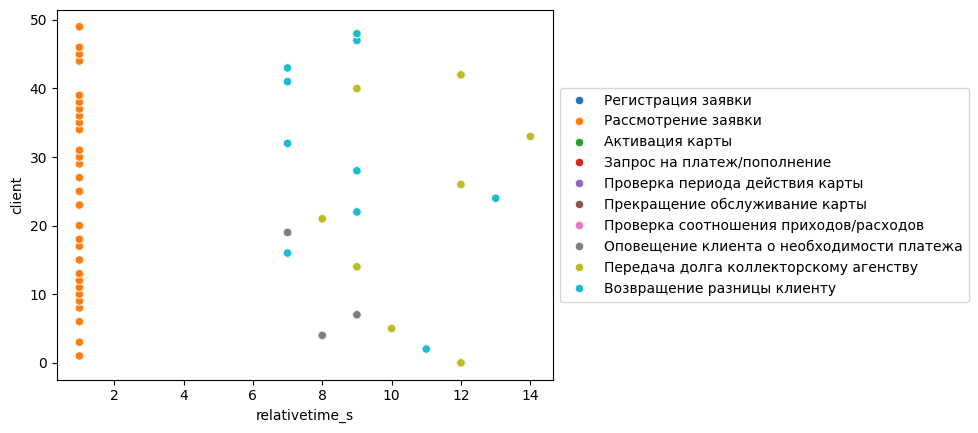

In [19]:
ax = sns.scatterplot(x=events['relativetime_s'], y=events['client'], hue=events['action'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

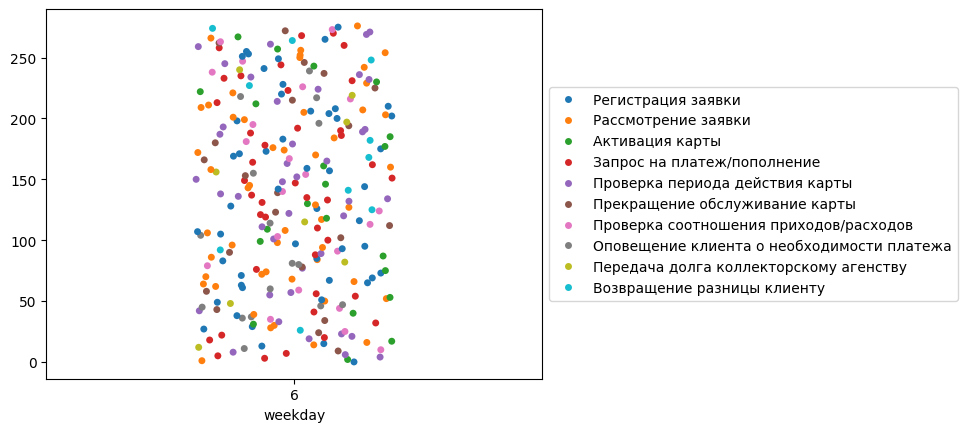

In [20]:
ax = sns.stripplot(x=events['weekday'], y=resourcenums, hue=events['action'], jitter=0.2)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

## 6.Реконструкция процесса алгоритмами ProcessMining

### Альфа майнер

parsing log, completed traces :: 100%|██████████| 50/50 [00:00<00:00, 8346.87it/s]
c:\Python311\Lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
c:\Python311\Lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
replaying log with TBR, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 1833.32it/s]


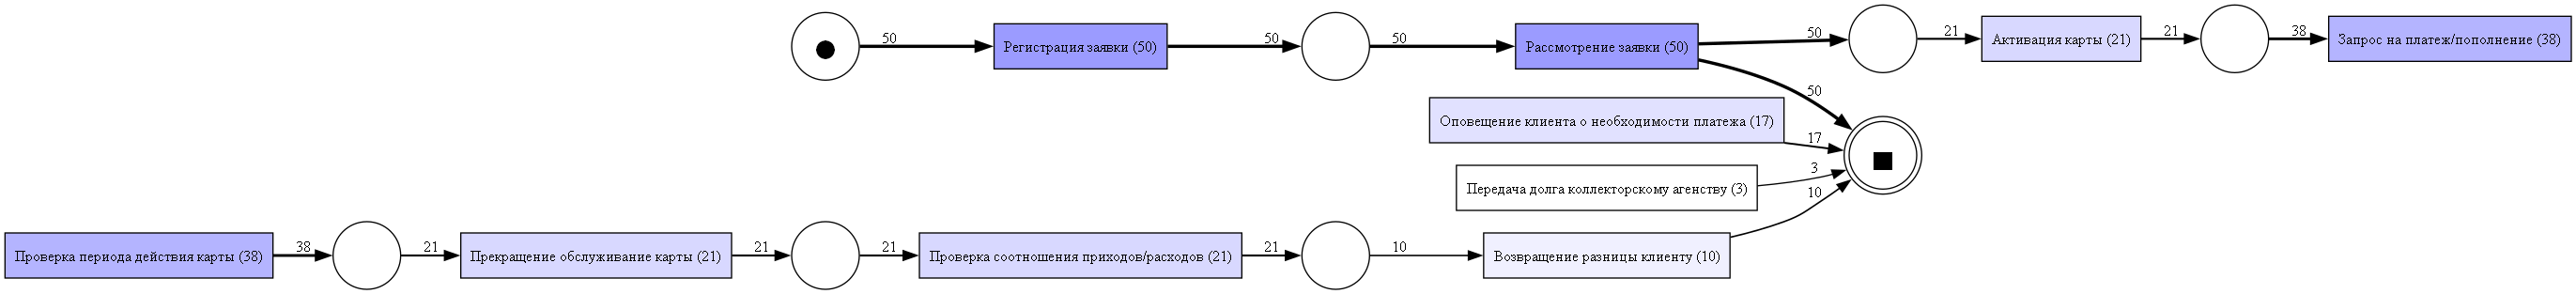

In [21]:

# alpha miner
simulated_log = read_xes('log.xes')

net, initial_marking, final_marking = alpha_miner.apply(simulated_log)

# Visualise
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking,
                            parameters=parameters,
                            variant=pn_visualizer.Variants.FREQUENCY,
                            log=simulated_log)
pn_visualizer.view(gviz)



### Альфа+ майнер

parsing log, completed traces :: 100%|██████████| 50/50 [00:00<00:00, 6219.87it/s]
C:\Users\cool1\AppData\Local\Temp\ipykernel_46000\1911189869.py:4: DeprecatedWarning: discover_petri_net_alpha_plus is deprecated as of 2.3.0 and will be removed in 3.0.0. this method will be removed in a future release.
  net, initial_marking, final_marking = discover_petri_net_alpha_plus(simulated_log)
c:\Python311\Lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
c:\Python311\Lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=T

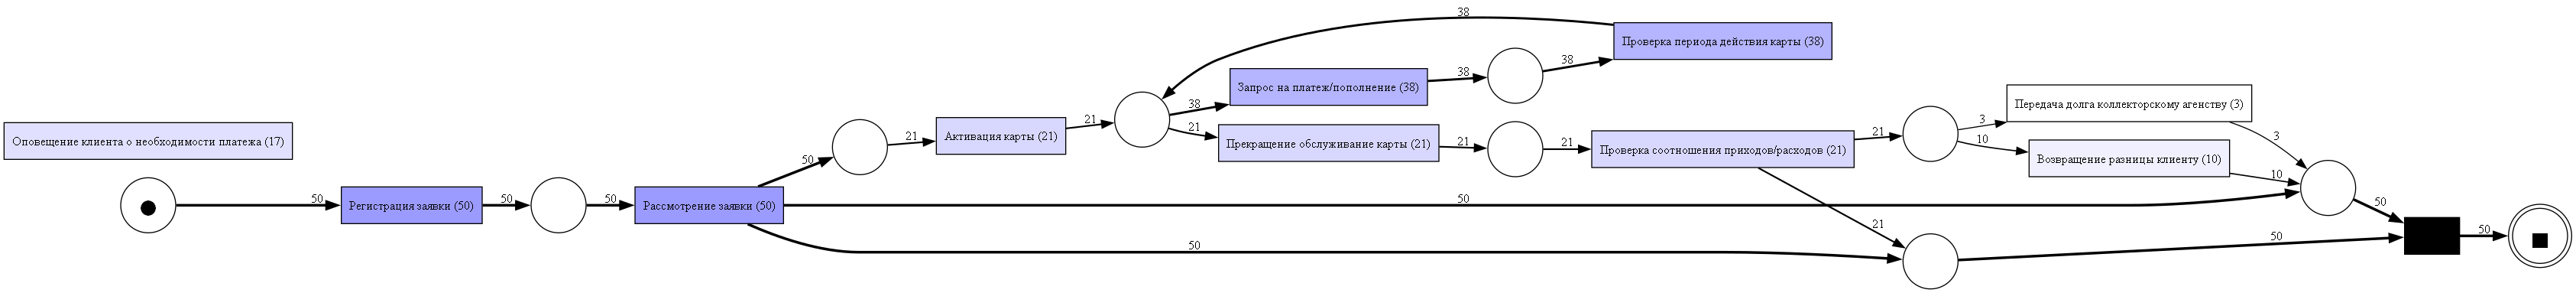

In [22]:

# alpha miner
simulated_log = read_xes('log.xes')

net, initial_marking, final_marking = discover_petri_net_alpha_plus(simulated_log)

# Visualise
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking,
                            parameters=parameters,
                            variant=pn_visualizer.Variants.FREQUENCY,
                            log=simulated_log)
pn_visualizer.view(gviz)


### Эвристический майнер

parsing log, completed traces :: 100%|██████████| 50/50 [00:00<00:00, 6784.92it/s]


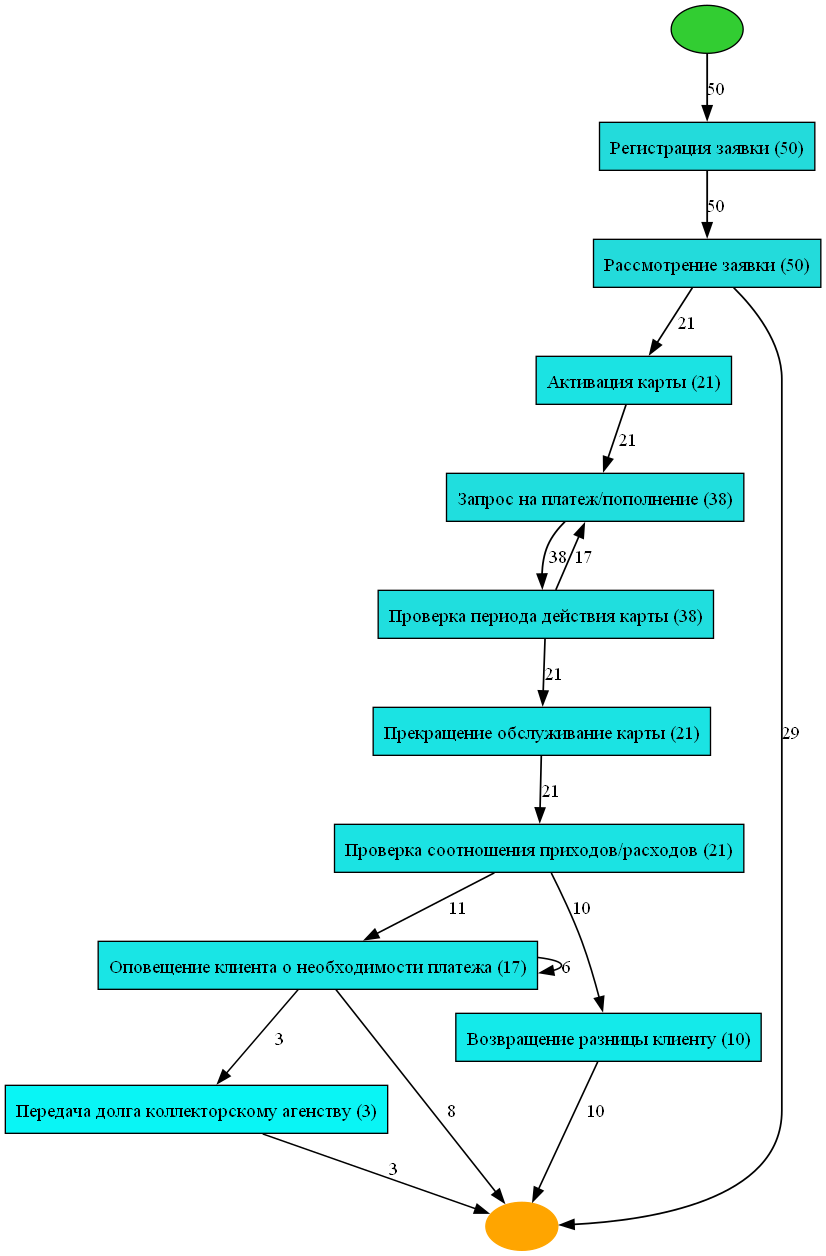

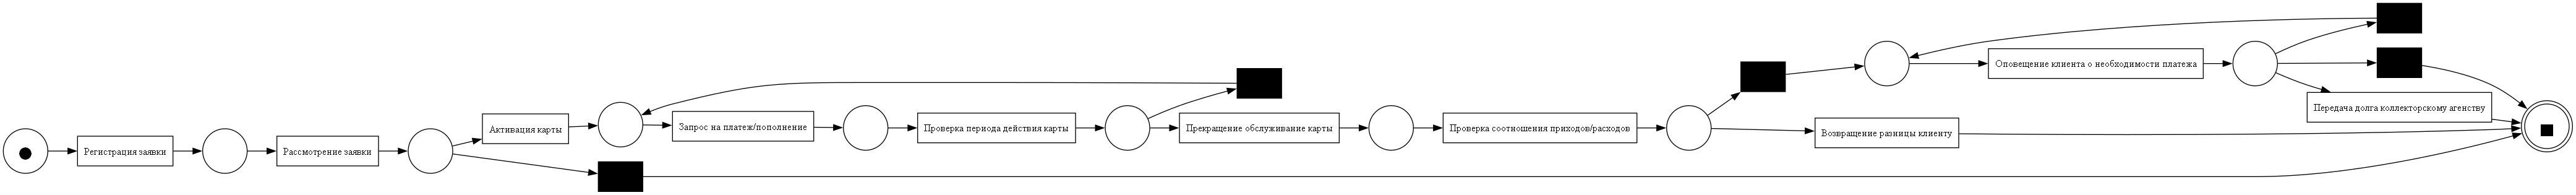

In [23]:

# heuristics miner
simulated_log = read_xes('log.xes')

heu_net = heuristics_miner.apply_heu(simulated_log)

# Visualise
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

#Petri-net of heuristic miner output
# heuristics miner
net, im, fm = heuristics_miner.apply(simulated_log)

# viz
gviz = pn_visualizer.apply(net, im, fm)

# pn_visualizer.view(gviz)
pn_visualizer.view(gviz)



### Индуктивный майнер

parsing log, completed traces :: 100%|██████████| 50/50 [00:00<00:00, 9999.77it/s]


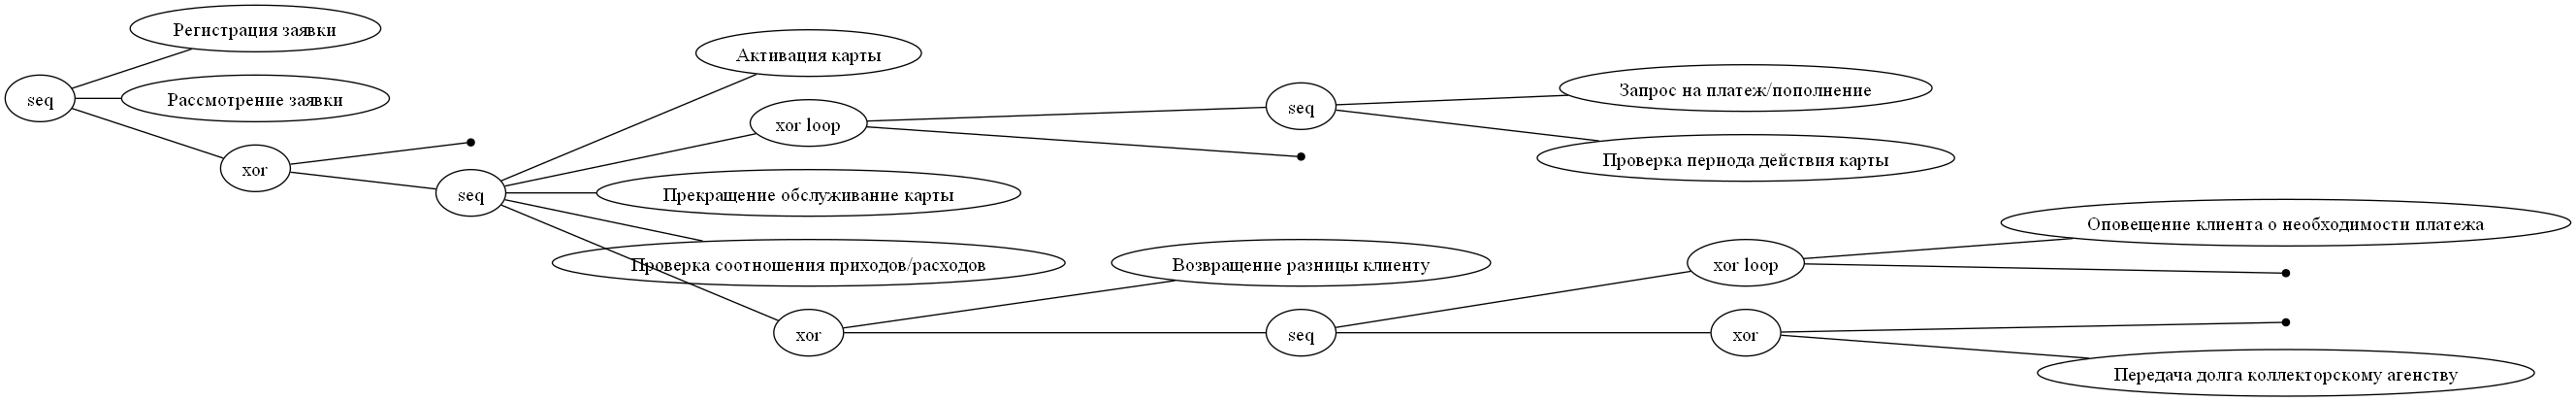

In [24]:
# create the process tree
simulated_log = read_xes('log.xes')
tree = inductive_miner.apply(simulated_log)

# viz
gviz = pt_visualizer.apply(tree)
pt_visualizer.view(gviz)